In [1]:
import os
import joblib
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import GradientBoostingClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, LSTM
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from datetime import datetime

In [2]:
# Defining global parameters
target_directory = "..\data" # Relative location of the FMCW radar data 

ML_model_path = "ML_Model_Doppler_3dB_Full\\"
if not os.path.exists(ML_model_path):
    os.mkdir(ML_model_path)
    
write_to_file = True

In [3]:
target_classifications_dict = {"Square_Doppler_3dB":0, "Triangle_Doppler_3dB":1, "Car":2, "Person":3} # Target classifications and their classes

dir_list = os.listdir(target_directory) # Extracting the list of all directories in the target location
target_class_list = list(target_classifications_dict.keys()) # List of target classifications
dir_exceptions = [dir_entry for dir_entry in dir_list if dir_entry not in target_class_list] # List of floders to ignore in the target directory


In [4]:
def Load_data(target_directory, dir_exceptions, target_classifications_dict, data_count=0):
    """
    Loads .npy files from all the directories within the target directory while ignoring the specified sub-directories
    target_directory: Primary directory location to import data
    dir_exceptions: List of sub-directories within the target directory to ignore
    target_classifications_dict: Dictionary with target sub-directory names as keys and respective class label as values
    data_count: Required number of measurement samples to load. The count is applied independently to each sub-directory within the target directory
    """
    FMCW_radar_data = [] # Empty list to store FMCW radar data
    target_classifications = [] # Empty list to store target class instances
    for root, folders, data in os.walk(target_directory): # Runs through the all folders, sub-folders and respective files within the root/target directory
        folders[:] = [folder for folder in folders if folder not in dir_exceptions] # Filtering to extract only the folders with required data
        data_len = len(data)
        count = data_len-data_count
        for file in data: # Iterating through each data file in each target class directory
            if count == data_len:
                break
            target_classifications.append(target_classifications_dict[root.split("\\")[-1]]) # Adding target class instances using values from target_classifications_dict dictionary
            FMCW_radar_data_path = root + '\\' + file # Generating the local path to each data file 
            FMCW_radar_data.append(np.load(FMCW_radar_data_path)) # Loading each data file into FMCW_radar_data list
            count += 1
    target_classifications = np.array(target_classifications) # Converting target class list to an array
    FMCW_radar_data = np.array(FMCW_radar_data) # Converting data list to an array
    
    return [FMCW_radar_data, target_classifications]

In [6]:
[FMCW_radar_data, target_classifications] = Load_data(target_directory, dir_exceptions, 
                                                      target_classifications_dict, data_count=4000)

X_train_full, X_test, y_train_full, y_test = train_test_split(
    FMCW_radar_data, target_classifications, test_size=0.2, random_state=99, 
    stratify=target_classifications) # Splitting the data to training and test sets
y_test_Cat = to_categorical(y_test, len(target_classifications_dict)) # Converting y_test to categorical


In [7]:
X_train, X_train_hpt, y_train, y_train_hpt = train_test_split(
    X_train_full, y_train_full, test_size=0.1, 
    random_state=99, stratify=y_train_full) # Splitting the data to training and test sets
y_train_Cat_hpt = to_categorical(y_train_hpt, len(target_classifications_dict)) # Converting y_train to categorical
y_train_Cat = to_categorical(y_train, len(target_classifications_dict)) # Converting y_train to categorical

In [8]:
def GBC_hyper_params_tuner(GBC_hyper_params, X_train_hpt, y_train_hpt):
    """
    Function to optimise hyper parameters for Gradient Boosting Classifier model
    """
    GBC_model = GradientBoostingClassifier() # Instantiating Gradient Boosting Classifier model
    GBC_GSCV = GridSearchCV(estimator=GBC_model, param_grid=GBC_hyper_params, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy') # Using GridSearchCV() for hyper-parameter tuning

    GBC_GSCV.fit(X_train_hpt, y_train_hpt) # Optimising hyper-parameters

    return GBC_GSCV

X_train_reshape_hpt = X_train_hpt.reshape(X_train_hpt.shape[0], -1) # Reshaping data to required format
GBC_hyper_params = {'n_estimators': [1, 2],
    'learning_rate': [0.65, 0.75, 0.85],
    'max_depth': [1, 2]
                   } # Defining a set of hyper-parameters to optimise

GBC_model_tuned = GBC_hyper_params_tuner(GBC_hyper_params, X_train_reshape_hpt, y_train_hpt) # Optimising hyper-parameters
print("GBC model best params: ", GBC_model_tuned.best_params_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
GBC model best params:  {'learning_rate': 0.85, 'max_depth': 2, 'n_estimators': 2}


In [9]:
time_start = datetime.now() # Measuring time to generate runtime-benchmark

X_train_reshape = X_train.reshape(X_train.shape[0], -1)

GBC_model_hyper_params = GBC_model_tuned.best_params_ # Obtaining optimised hyper-paramters
GBC_model = GradientBoostingClassifier(**GBC_model_hyper_params) # Instantiating model with optimised hyper-paramters
GBC_model.fit(X_train_reshape, y_train) # Training the model

X_test_reshape = X_test.reshape(X_test.shape[0], -1) # Reshaping data to required format

y_pred = GBC_model.predict(X_test_reshape) # Making predictions on test data
GBC_model_accuracy = accuracy_score(y_test, y_pred) # Estimating model performance
print("Gradient Boosting Classifier Accuracy: {}".format(GBC_model_accuracy)) # Printing model accuracy

time_end = datetime.now() # Measuring time to generate runtime-benchmark
GBC_model_run_time = time_end - time_start # Measuring time to generate runtime-benchmark
print(f"Gradient Boosting Classifier Excution Time: {GBC_model_run_time}") # Printing model runtime-benchmark


Gradient Boosting Classifier Accuracy: 0.999337528983107
Gradient Boosting Classifier Excution Time: 0:05:31.949730


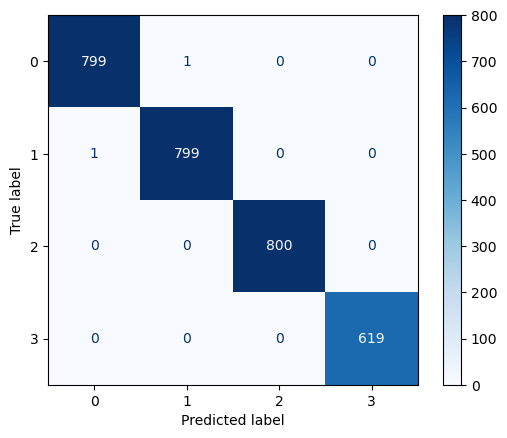

In [10]:
Confustion_Matrix = confusion_matrix(y_test, y_pred) # Generating confusion matrix

# Plotting confusion matrix
Confustion_Matrix_plot = ConfusionMatrixDisplay(confusion_matrix=Confustion_Matrix)
Confustion_Matrix_plot.plot(cmap=plt.cm.Blues)
plt.show()

In [11]:
if write_to_file: # Checking if a local copy needs to be saved
    GBC_model_path = ML_model_path + "GBC_Classifier.joblib" # Genarating the file local path
    joblib.dump(GBC_model, GBC_model_path) # Saving the trained model locally

In [52]:
def RNN_model_gen(dropout=0.2, activation_function='softmax', optimizer='adam'):
    """
    Function to instantiate and RNN Classifier model
    """
    RNN_model = Sequential() # Instantiating a tensorflow class
    RNN_model.add(tf.keras.Input(shape=(256,64))) # Defining the input layer
    RNN_model.add(SimpleRNN(units=64, activation=activation_function, return_sequences=True)) # Adding RNN layer
    RNN_model.add(Dropout(dropout)) # Adding a dropout layer
    RNN_model.add(SimpleRNN(units=32, activation=activation_function)) # Adding RNN layer
    RNN_model.add(Dropout(dropout)) # Adding a dropout layer
    RNN_model.add(Dense(len(target_classifications_dict), activation='sigmoid')) # Adding a dense output layer
    
    RNN_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) # Compiling the RNN model
    return RNN_model

def LSTM_model_gen(dropout=0.2, activation_function='softmax', optimizer='adam'):
    """
    Function to instantiate and LSTM Classifier model
    """
    LSTM_model = Sequential() # Instantiating a tensorflow class
    LSTM_model.add(tf.keras.Input(shape=(256,64))) # Defining the input layer
    LSTM_model.add(LSTM(units=128, activation=activation_function, return_sequences=True)) # Adding LSTM layer
    LSTM_model.add(Dropout(dropout)) # Adding a dropout layer
    LSTM_model.add(LSTM(units=32, activation=activation_function)) # Adding LSTM layer
    LSTM_model.add(Dropout(dropout)) # Adding a dropout layer
    LSTM_model.add(Dense(len(target_classifications_dict), activation='sigmoid')) # Adding a dense output layer
        
    LSTM_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) # Compiling the LSTM model
    
    return LSTM_model

def MLP_model_gen(activation_function='softmax'):
    """
    Function to instantiate and MLP Classifier model
    """
    MLP_model = Sequential() # Instantiating a tensorflow class
    MLP_model.add(tf.keras.Input(shape=(256, 64))) # Defining the input layer 
    MLP_model.add(tf.keras.layers.Flatten()) # Adding flatten layer to reshape the data to 1-D format
    MLP_model.add(Dense(128, activation=activation_function)) # Adding a dense layer
#     MLP_model.add(Dropout(dropout)) # Adding a dropout layer
    MLP_model.add(Dense(64, activation=activation_function)) # Adding a dense layer
#     MLP_model.add(Dropout(dropout)) # Adding a dropout layer
    MLP_model.add(Dense(16, activation=activation_function)) # Adding a dense layer
    MLP_model.add(Dense(len(target_classifications_dict))) # Adding a dense output layer     
    
    MLP_model.compile(optimizer='adam', 
#                       loss='categorical_crossentropy',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy']) # Compiling the MLP model
    
    return MLP_model   

def CNN_model_gen(units_Dense=32, activation_Cv2D='relu', activation_Dense='relu'):
    """
    Function to instantiate and CNN Classifier model
    """
    CNN_model = Sequential() # Instantiating a tensorflow class
    CNN_model.add(tf.keras.Input(shape=(256,64, 1))) # Defining the input layer  
    CNN_model.add(tf.keras.layers.Conv2D(16, (3, 3), activation=activation_Cv2D)) # Adding a 2D Convolutional layer
    CNN_model.add(tf.keras.layers.MaxPooling2D((2, 2))) # Adding a MaxPooling2D layer
    CNN_model.add(tf.keras.layers.Conv2D(128, (3, 3), activation=activation_Cv2D)) # Adding a 2D Convolutional layer
    CNN_model.add(tf.keras.layers.MaxPooling2D((2, 2))) # Adding a MaxPooling2D layer   
    CNN_model.add(tf.keras.layers.Conv2D(32, (3, 3), activation=activation_Cv2D)) # Adding a 2D Convolutional layer
    CNN_model.add(tf.keras.layers.MaxPooling2D((2, 2))) # Adding a MaxPooling2D layer 
    CNN_model.add(tf.keras.layers.Flatten()) # Adding flatten layer to reshape the data to 1-D format
    CNN_model.add(tf.keras.layers.Dense(units_Dense, activation=activation_Dense)) # Adding a dense layer
    CNN_model.add(tf.keras.layers.Dense(len(target_classifications_dict), activation='softmax')) # Adding a dense output layer
    
    CNN_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) # Compiling the CNN model
    
    return CNN_model

### RNN

In [14]:
RNN_model = KerasClassifier(model=RNN_model_gen, verbose=0) # Instantiating a KerasClassifier for hyper-parameter tuning

RNN_hyper_params = {
    'model__dropout': [0.1, 0.2, 0.3],
    'model__activation_function': ['relu', 'softmax', 'sigmoid'],
    'model__optimizer': ['adam', 'rmsprop'],
#     'batch_size': [16, 32, 64],
    'epochs': [10, 20, 30]
} # Defining a set of hyper-parameters to optimise

RNN_Optimiser = RandomizedSearchCV(estimator=RNN_model, 
                                   param_distributions=RNN_hyper_params, 
                                   n_iter=5,   # Number of hyper-parameter combinations
                                   cv=3,       # Number of cross-validation folds
                                   verbose=2)  # Using RandomizedSearchCV() for hyper-parameter tuning

RNN_Optimiser.fit(X_train_hpt, y_train_Cat_hpt) # Optimising hyper-parameters
clear_output() 

RNN_best_params = RNN_Optimiser.best_params_ # Saving Optimised hyper-parameters
RNN_best_params


{'model__optimizer': 'rmsprop',
 'model__dropout': 0.2,
 'model__activation_function': 'sigmoid',
 'epochs': 30}

In [15]:
time_start = datetime.now() # Measuring time to generate runtime-benchmark

RNN_model = RNN_model_gen(dropout=RNN_best_params['model__dropout'], 
                          activation_function=RNN_best_params['model__activation_function'], 
                          optimizer=RNN_best_params['model__optimizer']) # Instantiating model with optimised hyper-paramters

RNN_model.fit(X_train, y_train_Cat, epochs=RNN_best_params['epochs'], validation_split=0.2, verbose=True) # Training the model

clear_output()
loss, accuracy = RNN_model.evaluate(X_test, y_test_Cat) # Estimating model performance

time_end = datetime.now() # Measuring time to generate runtime-benchmark
RNN_model_run_time = time_end - time_start # Measuring time to generate runtime-benchmark
print(f"RNN Model Excution Time: {RNN_model_run_time}") # Printing model runtime-benchmark


95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9843 - loss: 0.0461
RNN Model Excution Time: 0:05:31.249677


95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


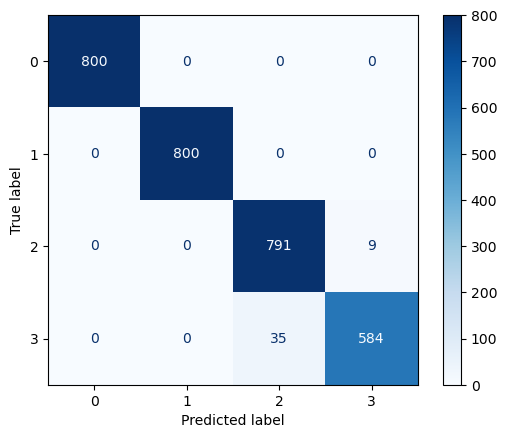

In [16]:
RNN_y_pred_Cat = RNN_model.predict(X_test) # Making predictions on test data
RNN_y_pred = np.argmax(RNN_y_pred_Cat, axis=1) # Reformatting predicted data to the format of actual data

Confustion_Matrix = confusion_matrix(y_test, RNN_y_pred) # Generating confusion matrix

# Plotting confusion matrix
Confustion_Matrix_plot = ConfusionMatrixDisplay(confusion_matrix=Confustion_Matrix)
Confustion_Matrix_plot.plot(cmap=plt.cm.Blues)
plt.show()

In [17]:
if write_to_file: # Checking if a local copy needs to be saved
    RNN_model_path = ML_model_path + "RNN_Classifier.joblib" # Genarating the file local path
    joblib.dump(RNN_model, RNN_model_path) # Saving the trained model locally

### LSTM

In [18]:
LSTM_model = KerasClassifier(model=LSTM_model_gen, verbose=0) # Instantiating a KerasClassifier for hyper-parameter tuning

LSTM_hyper_params = {
    'model__dropout': [0.1, 0.2, 0.3],
    'model__activation_function': ['relu', 'softmax', 'sigmoid'],
    'model__optimizer': ['adam', 'rmsprop'],
#     'batch_size': [16, 32, 64],
    'epochs': [10, 20, 30]
} # Defining a set of hyper-parameters to optimise

LSTM_Optimiser = RandomizedSearchCV(estimator=LSTM_model, 
                                   param_distributions=LSTM_hyper_params, 
                                   n_iter=10,  # Number of hyper-parameter combinations
                                   cv=3,       # Number of cross-validation folds
                                   verbose=2)  # Using RandomizedSearchCV() for hyper-parameter tuning

LSTM_Optimiser.fit(X_train_hpt, y_train_Cat_hpt) # Optimising hyper-parameters
clear_output() 

LSTM_best_params = LSTM_Optimiser.best_params_ # Saving Optimised hyper-parameters
LSTM_best_params

{'model__optimizer': 'adam',
 'model__dropout': 0.3,
 'model__activation_function': 'sigmoid',
 'epochs': 20}

In [19]:
time_start = datetime.now() # Measuring time to generate runtime-benchmark

LSTM_model = LSTM_model_gen(dropout=LSTM_best_params['model__dropout'], 
                          activation_function=LSTM_best_params['model__activation_function'], 
                          optimizer=LSTM_best_params['model__optimizer']) # Instantiating model with optimised hyper-paramters

LSTM_model.fit(X_train, y_train_Cat, epochs=LSTM_best_params['epochs'], validation_split=0.2, verbose=True) # Training the model

clear_output()
loss, accuracy = LSTM_model.evaluate(X_test, y_test_Cat) # Estimating model performance

time_end = datetime.now() # Measuring time to generate runtime-benchmark
LSTM_model_run_time = time_end - time_start # Measuring time to generate runtime-benchmark
print(f"RNN Model Excution Time: {LSTM_model_run_time}") # Printing model runtime-benchmark


95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9987 - loss: 0.0173
RNN Model Excution Time: 0:10:04.345358


95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step


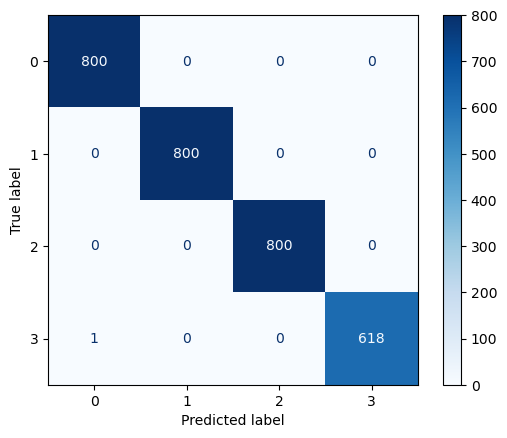

In [20]:
LSTM_y_pred_Cat = LSTM_model.predict(X_test) # Making predictions on test data
LSTM_y_pred = np.argmax(LSTM_y_pred_Cat, axis=1) # Reformatting predicted data to the format of actual data

Confustion_Matrix = confusion_matrix(y_test, LSTM_y_pred) # Generating confusion matrix

# Plotting confusion matrix
Confustion_Matrix_plot = ConfusionMatrixDisplay(confusion_matrix=Confustion_Matrix)
Confustion_Matrix_plot.plot(cmap=plt.cm.Blues)
plt.show()

In [21]:
if write_to_file: # Checking if a local copy needs to be saved
    LSTM_model_path = ML_model_path + "LSTM_Classifier.joblib" # Genarating the file local path
    joblib.dump(LSTM_model, LSTM_model_path) # Saving the trained model locally

### Multilayer Perceptron (MLP)

In [39]:
MLP_model = KerasClassifier(model=MLP_model_gen, verbose=0) # Instantiating a KerasClassifier for hyper-parameter tuning

MLP_hyper_params = {
    'model__activation_function': ['relu', 'softmax', 'sigmoid'],
    'batch_size': [16, 32, 64],  
    'epochs': [10, 20, 30]
} # Defining a set of hyper-parameters to optimise

MLP_Optimiser = RandomizedSearchCV(estimator=MLP_model, 
                                   param_distributions=MLP_hyper_params, 
                                   n_iter=10,  # Number of hyper-parameter combinations
                                   cv=3,       # Number of cross-validation folds
                                   verbose=2)  # Using RandomizedSearchCV() for hyper-parameter tuning

MLP_Optimiser.fit(X_train_hpt, y_train_hpt) # Optimising hyper-parameters
clear_output() 

MLP_best_params = MLP_Optimiser.best_params_ # Saving Optimised hyper-parameters
MLP_best_params

{'model__activation_function': 'relu', 'epochs': 10, 'batch_size': 64}

In [53]:
time_start = datetime.now() # Measuring time to generate runtime-benchmark

MLP_model = MLP_model_gen(activation_function=MLP_best_params['model__activation_function']) # Instantiating model with optimised hyper-paramters
                         
MLP_model.fit(X_train, y_train, epochs=MLP_best_params['epochs'], validation_split=0.2, verbose=True) # Training the model

clear_output()
loss, accuracy = MLP_model.evaluate(X_test, y_test) # Estimating model performance

time_end = datetime.now() # Measuring time to generate runtime-benchmark
MLP_model_run_time = time_end - time_start # Measuring time to generate runtime-benchmark
print(f"RNN Model Excution Time: {MLP_model_run_time}") # Printing model runtime-benchmark


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8908 - loss: 2.1013
RNN Model Excution Time: 0:00:36.425171


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


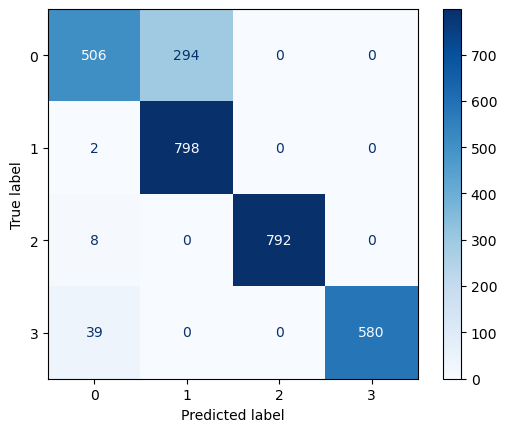

In [55]:
MLP_y_pred_Cat = MLP_model.predict(X_test) # Making predictions on test data
MLP_y_pred = np.argmax(MLP_y_pred_Cat, axis=1) # Reformatting predicted data to the format of actual data

Confustion_Matrix = confusion_matrix(y_test, MLP_y_pred) # Generating confusion matrix

# Plotting confusion matrix
Confustion_Matrix_plot = ConfusionMatrixDisplay(confusion_matrix=Confustion_Matrix)
Confustion_Matrix_plot.plot(cmap=plt.cm.Blues)
plt.show()

In [56]:
if write_to_file: # Checking if a local copy needs to be saved
    MLP_model_path = ML_model_path + "MLP_Classifier.joblib" # Genarating the file local path
    joblib.dump(MLP_model, MLP_model_path) # Saving the trained model locally

### Convolutional Neural Network (CNN)

In [26]:
CNN_model = KerasClassifier(model=CNN_model_gen, verbose=0) # Instantiating a KerasClassifier for hyper-parameter tuning

CNN_hyper_params = {
    'model__units_Dense': [16, 32],
    'model__activation_Cv2D': ['relu', 'tanh', 'sigmoid'],
    'model__activation_Dense': ['relu', 'tanh', 'sigmoid'],
    'epochs': [10, 20],
    'batch_size': [32, 64]
} # Defining a set of hyper-parameters to optimise

CNN_Optimiser = RandomizedSearchCV(estimator=CNN_model, 
                                   param_distributions=CNN_hyper_params, 
                                   n_iter=5,   # Number of hyper-parameter combinations
                                   cv=3,       # Number of cross-validation folds
                                   verbose=2)  # Using RandomizedSearchCV() for hyper-parameter tuning

X_train_hpt_reshape = X_train_hpt.reshape((X_train_hpt.shape[0], 256, 64, 1)) # Reshaping data to required format
CNN_Optimiser.fit(X_train_hpt_reshape, y_train_hpt) # Optimising hyper-parameters
clear_output() 

CNN_best_params = CNN_Optimiser.best_params_ # Saving Optimised hyper-parameters
CNN_best_params

{'model__units_Dense': 16,
 'model__activation_Dense': 'relu',
 'model__activation_Cv2D': 'tanh',
 'epochs': 20,
 'batch_size': 64}

In [27]:
time_start = datetime.now() # Measuring time to generate runtime-benchmark

CNN_model = CNN_model_gen(units_Dense=CNN_best_params['model__units_Dense'], 
                          activation_Cv2D=CNN_best_params['model__activation_Cv2D'],
                          activation_Dense=CNN_best_params['model__activation_Dense']
                         ) # Instantiating model with optimised hyper-paramters

X_train_reshape = X_train.reshape((X_train.shape[0], 256, 64, 1)) # Reshaping data to required format
CNN_model.fit(X_train_reshape, y_train, epochs=CNN_best_params['epochs'], validation_split=0.2, verbose=True) # Training the model

clear_output()
X_test_reshape = X_test.reshape((X_test.shape[0], 256, 64, 1)) # Reshaping data to required format
loss, accuracy = CNN_model.evaluate(X_test_reshape, y_test) # Estimating model performance

time_end = datetime.now() # Measuring time to generate runtime-benchmark
CNN_model_run_time = time_end - time_start # Measuring time to generate runtime-benchmark
print(f"RNN Model Excution Time: {CNN_model_run_time}") # Printing model runtime-benchmark


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 1.0000 - loss: 8.5807e-06
RNN Model Excution Time: 0:08:04.550149


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


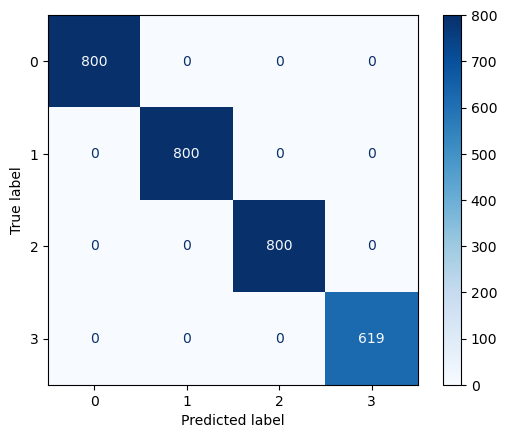

In [28]:
CNN_y_pred_Cat = CNN_model.predict(X_test_reshape) # Making predictions on test data
CNN_y_pred = np.argmax(CNN_y_pred_Cat, axis=1) # Reformatting predicted data to the format of actual data

Confustion_Matrix = confusion_matrix(y_test, CNN_y_pred) # Generating confusion matrix

# Plotting confusion matrix
Confustion_Matrix_plot = ConfusionMatrixDisplay(confusion_matrix=Confustion_Matrix)
Confustion_Matrix_plot.plot(cmap=plt.cm.Blues)
plt.show()

In [29]:
if write_to_file: # Checking if a local copy needs to be saved
    CNN_model_path = ML_model_path + "CNN_Classifier.joblib" # Genarating the file local path
    joblib.dump(CNN_model, CNN_model_path) # Saving the trained model locally